<a href="https://colab.research.google.com/github/kraken114/Colab/blob/main/3D_Deep_learning_3_%D1%81%D1%82%D1%80_83_%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BE%D1%82%D1%81%D0%BB%D0%B5%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE%D0%B7%D1%8B_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ГЛАВА 4**

# **По картинке находим такой же ракурс 3D модели**



---



---



---



---



---



---



# **Это необходимо для использования графики в Colab**

**1. Вначале необходимо импортировать все требующиеся модули Python:**

In [ ]:
%%capture
# блок установки pytorch3d
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
%%capture
!pip install open3d
!wget https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj
import numpy as np
import plotly.graph_objects as go
import open3d as o3d
from pytorch3d.io import load_ply
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# https://linkhs.github.io/Colab/Open3D/Open3D_visualization.html
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == open3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == open3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
# draw_geometries('/content/cube.ply')

# **Конец необхдимого**



---



---



---



---



---



---



# **1. Подгонка силуэта**

# **стр. 93**

**1. Исходный код в файле Python diff_render.py начинается с импорта необходимых** **пакетов:**

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
FoVPerspectiveCameras, look_at_view_transform,
look_at_rotation, RasterizationSettings,
MeshRenderer, MeshRasterizer,
BlendParams, SoftSilhouetteShader, HardPhongShader,
PointLights, TexturesVertex,
)

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
  print("ПРЕДУПРЕЖДЕНИЕ: только CPU, очень медленно!")

**3. Задаем выходной каталог output_dir**

In [ ]:
output_dir = '/content/result_teapot'

In [ ]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
mesh_file = '/content/teapot.obj'
print('Визуализация полигональной сетки с помощью Open3D')
mesh = o3d.io.read_triangle_mesh(mesh_file)
# open3d.visualization.draw_geometries([mesh],
# mesh_show_wireframe=True,
# mesh_show_back_face=True)


o3d.visualization.draw_geometries = draw_geometries # replace function
# o3d.visualization.draw_geometries([cloud])
o3d.visualization.draw_geometries([mesh])



# open3d.visualization.draw_geometries([mesh])


# print('Загрузка того же файла с помощью PyTorch3D')
# vertices, faces, aux = load_obj(mesh_file)
# print('Тип vertices = ', type(vertices))
# print('Type faces = ', type(faces))
# print('Тип aux = ', type(aux))
# print('vertices = ', vertices)
# print('faces = ', faces)
# print('aux = ', aux)

Визуализация полигональной сетки с помощью Open3D


**4. Затем загружаем сеточную модель из OBJ-файла ./data/** **teapot.obj. Поскольку эта сеточная модель не сопровождается** **текстурами (значениями материального** **цвета), мы создаем единый тензор и делаем его текстурой для** **сеточной модели. В итоге мы получаем сеточную модель с** **текстурами в качестве переменной teapot_mesh:**

In [ ]:
# это с CUDA
verts, faces_idx, _ = load_obj("/content/teapot.obj")
faces = faces_idx.verts_idx
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))
teapot_mesh = Meshes(verts=[verts.to(device)],
                      faces=[faces.to(device)],
                      textures=textures)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning:

No mtl file provided



**5. Далее в следующей строке задаем модель камеры.**

In [ ]:
cameras = FoVPerspectiveCameras(device=device)

**6. Переобразуем полигональную модель в точечный** **рисунок**

**6. На следующем шаге определяется дифференцируемый ** **отрисовщик с именем silhouette_renderer**

**blend_params** - гиперпараметры затенителя определены здесь

**MeshRasterizer** - используется для растеризации

**blur_radius** – это пороговое значение для отыскания
соответствующих граней полигональной сетки

**faces_per_Pixel** – максимальное число граней полигональной сетки, которое будет возвращено для каждого пиксела изображения

**Растеризовать** - преобразовать содержимое этих слоев в обычное, точечное изображение.

In [ ]:
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(image_size=256,
                                    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
                                    faces_per_pixel=100,)
silhouette_renderer = MeshRenderer(rasterizer=MeshRasterizer(
                                    cameras=cameras,
                                    raster_settings=raster_settings),
                                    shader=SoftSilhouetteShader(blend_params=blend_params)
                                    )

**8. Затем определяем источник света lights с** **координатами 2.0, 2.0 и -2.0:**

In [ ]:
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
    )
lights = PointLights(
    device=device,
    location=((2.0, 2.0, -2.0),)
    )
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
      cameras=cameras,
      raster_settings=raster_settings
    ),
    shader=HardPhongShader(
      device=device,
      cameras=cameras,
      lights=lights
    )
)

**9. Далее задаем местоположение камеры и вычисляем** **соответствующий поворот R и смещение T камеры.**

In [ ]:
distance = 3
elevation = 50.0
azimuth = 0.0
R, T = look_at_view_transform(distance,
                              elevation,
                              azimuth,
                              device=device)

**10. Теперь генерируем изображение image_ref из этой** **позиции камеры.**

In [ ]:
silhouette = silhouette_renderer(meshes_world=teapot_mesh,
        R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh,
        R=R, T=T)
silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()
plt.figure(figsize=(10, 10))
# Рисовать только альфа-канал RGBA-изображения
plt.imshow(silhouette.squeeze()[..., 3])
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_silhouette.png'))
plt.close()
plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_rgb.png'))
plt.close()

**11. На следующем шаге определяем класс Model**

На входе принимает **meshes** для сеточных моделей, отрисовщик **renderer** и **image_ref** в качестве целевого изображения

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)

        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image

**12. Создаем экземпляр данного класса и определить** **оптимизатор**

Это **силуэтное изображение в стартовой**
**позиции** камеры будет сохранено в PNG-файле startup_silhouette.png:

In [ ]:
model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

_, image_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, 'starting_silhouette.png'))
plt.close()

In [ ]:
for i in range(0, 200):
    if i%10 == 0:
        print('i = ', i)

    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    if loss.item() < 500:
        break


    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)

    plt.figure()
    plt.imshow(image[..., :3])
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'fitting_' + str(i) + '.png'))
    plt.close()

print('Finished')

i =  0
i =  10
i =  20
i =  30
i =  40
i =  50
i =  60
i =  70
Finished


# **1. Подгонка силуэта и текстуры**

In [ ]:
# 1. На первом шаге импортируем все необходимые пакеты:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
FoVPerspectiveCameras, look_at_view_transform,
look_at_rotation, RasterizationSettings,
MeshRenderer, MeshRasterizer, BlendParams,
SoftSilhouetteShader, HardPhongShader,
PointLights, SoftPhongShader
)

In [ ]:
# 2. Далее создаем устройство PyTorch, используя графический процессор(ы)
# либо центральный процессор(ы):
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.cuda.set_device(device)
else:
  device = torch.device("cpu")

In [ ]:
# 3. Задаем result_cow в качестве выходного каталога output_dir. Это будет
# папка, в которой будут сохраняться результаты подгонки:
output_dir = '/content/result_cow'

In [ ]:
# 4. Загружаем сеточную модель игрушечной коровы из OBJ-файла cow.obj:
obj_filename = "/content/cow.obj"
cow_mesh = load_objs_as_meshes([obj_filename],
device=device)

In [ ]:
mesh_file = '/content/cow.obj'
print('Визуализация полигональной сетки с помощью Open3D')
mesh = o3d.io.read_triangle_mesh(mesh_file)

o3d.visualization.draw_geometries = draw_geometries
o3d.visualization.draw_geometries([mesh])

Визуализация полигональной сетки с помощью Open3D


In [ ]:
# 5. Определяем камеры и источники света, как показано ниже:
cameras = FoVPerspectiveCameras(device=device)
lights = PointLights(device=device,
location=((2.0, 2.0, -2.0),))

In [ ]:
# 6. Далее создаем силуэтный отрисовщик renderer_silhouette. Это диффе-
# ренцируемый отрисовщик для отрисовки силуэтных изображений. Об-
# ратите внимание на числовые значения парметров blur_radius и faces_
# per_pixel. Этот отрисовщик используется главным образом в подгонке
# силуэтов:
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)

renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

In [ ]:
# 7. Далее создаем текстурированный отрисовщик renderer_textured. Это
# еще один дифференцируемый отрисовщик, в основном используемый
# для отрисовки RGB-изображений:
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device,
        cameras=cameras,
        lights=lights)
)

In [ ]:
# 8. Далее создаем фонговский отрисовщик phong_renderer. Этот отрисов-
# щик используется главным образом для визуализации. Приведенные
# выше дифференцируемые отрисовщики тяготеют к созданию размы-
# тых изображений. Поэтому нам было бы неплохо иметь отрисовщик,
# который способен генерировать четкие изображения:
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

In [ ]:
# 9. Далее зададим позицию камеры, а также соответствующий поворот
# и позицию камеры. Это будет позиция камеры, в которой будет снято
# наблюдаемое изображение. Как и в предыдущем примере, вместо ори-
# ентации и позиции объекта мы оптимизируем ориентацию и позицию
# камеры. Кроме того, мы исходим из допущения, что камера всегда на-
# правлена на объект. Таким образом, требуется оптимизировать только
# позицию камеры:
distance = 3
elevation = 50.0
azimuth = 0.0
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

In [ ]:
# 10. Далее создаем наблюдаемые изображения и сохраняем их в PNG-файлах
# target_silhouette.png и target_rgb.png. Указанные изображения так-
# же хранятся в переменных silhouette и image_ref:
silhouette = renderer_silhouette(meshes_world=cow_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=cow_mesh, R=R, T=T)
silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_silhouette.png'))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_rgb.png'))
plt.close()

In [ ]:
# 11. Теперь видоизменим определение класса Model, как показано ниже.
# Наиболее заметные изменения, по сравнению с предыдущим приме-
# ром, заключаются в том, что теперь мы будем отрисовывать и изобра-
# жение альфа-канала, и RGB-изображения и сравнивать их с наблюдае-
# мыми изображениями. Среднеквадратические потери в альфа-канале
# и RGB-каналах взвешиваются, давая окончательное значение потери:
class Model(nn.Module):
    def __init__(self, meshes, renderer_silhouette, renderer_textured, image_ref, weight_silhouette, weight_texture):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer_silhouette = renderer_silhouette
        self.renderer_textured = renderer_textured

        self.weight_silhouette = weight_silhouette
        self.weight_texture = weight_texture

        image_ref_silhouette = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref_silhouette', image_ref_silhouette)

        image_ref_textured = torch.from_numpy((image_ref[..., :3]).astype(np.float32))
        self.register_buffer('image_ref_textured', image_ref_textured)

        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image_silhouette = self.renderer_silhouette(meshes_world=self.meshes.clone(), R=R, T=T)
        image_textured = self.renderer_textured(meshes_world=self.meshes.clone(), R=R, T=T)

        loss_silhouette = torch.sum((image_silhouette[..., 3] - self.image_ref_silhouette) ** 2)
        loss_texture = torch.sum((image_textured[..., :3] - self.image_ref_textured) ** 2)

        loss = self.weight_silhouette * loss_silhouette + self.weight_texture * loss_texture
        return loss, image_silhouette, image_textured

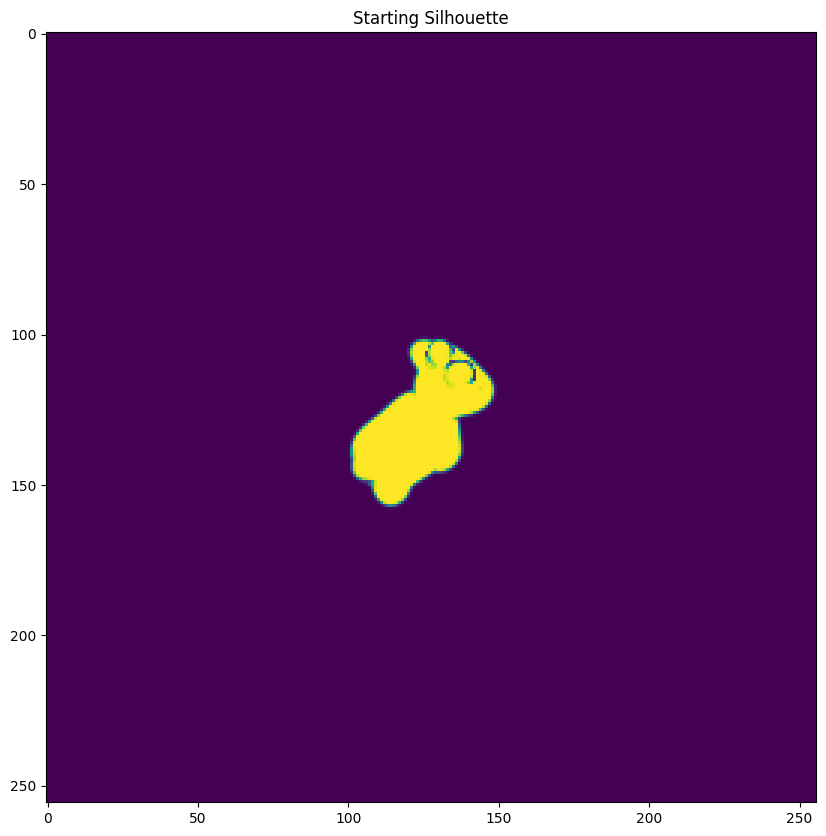

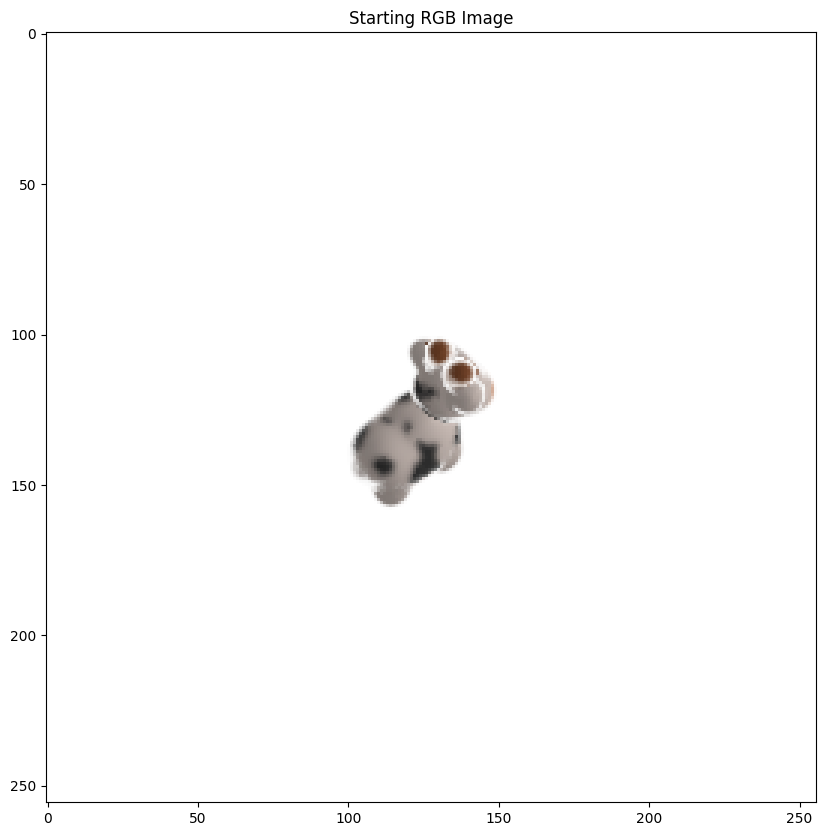

In [ ]:
# 12. Далее создаем экземпляр класса Model и создаем оптимизатор:
model = Model(meshes=cow_mesh, renderer_silhouette=renderer_silhouette, renderer_textured = renderer_textured,
              image_ref=image_ref, weight_silhouette=1.0, weight_texture=0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

_, image_silhouette_init, image_rgb_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_silhouette_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, 'starting_silhouette.png'))

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb_init.cpu().detach().numpy().squeeze())
plt.grid(False)
plt.title("Starting RGB Image");
plt.savefig(os.path.join(output_dir, 'starting_rgb.png'))

In [ ]:
# 13. Наконец, выполняем 200 итераций оптимизации. Отрисованные изо-
# бражения сохраняются на каждой итерации:
for i in range(0, 200):
    if i%10 == 0:
        print('i = ', i)

    optimizer.zero_grad()
    loss, image_silhouette, image_textured = model()
    loss.backward()
    optimizer.step()

    plt.figure()
    plt.imshow(image_silhouette[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_silhouette_' + str(i) + '.png'))
    plt.close()

    plt.figure()
    plt.imshow(image_textured.detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_texture_' + str(i) + '.png'))
    plt.close()

    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)

    plt.figure()
    plt.imshow(image[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_silhouette_' + str(i) + '.png'))
    plt.close()

    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)

    plt.figure()
    plt.imshow(image[..., :3])
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_texture_' + str(i) + '.png'))
    plt.close()

    if loss.item() < 800:
        break

print('Finished')

i =  0
i =  10
i =  20
i =  30
i =  40
i =  50
i =  60
i =  70
i =  80
i =  90
i =  100
i =  110
i =  120
i =  130
i =  140
i =  150
i =  160
i =  170
i =  180
i =  190
Finished
